<a href="https://www.kaggle.com/code/bhanupratapbiswas/binary-classification-insurance?scriptVersionId=188776961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# Data overview

In [2]:
%%time
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
train.shape, test.shape, train.isnull().values.any(), test.isnull().values.any(), train.duplicated().sum(), test.duplicated().sum()

CPU times: user 46.2 s, sys: 7.34 s, total: 53.5 s
Wall time: 1min 2s


((11504798, 12), (7669866, 11), False, False, 0, 0)

In [3]:
train.sample(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
4298655,4298655,Male,25,1,28.0,1,< 1 Year,No,28897.0,152.0,169,0
7740615,7740615,Male,33,1,28.0,1,< 1 Year,No,39445.0,152.0,131,0
9155336,9155336,Female,24,1,2.0,1,< 1 Year,No,25208.0,152.0,126,0


In [4]:
test.sample(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
6573657,18078455,Male,23,1,41.0,1,< 1 Year,No,33513.0,26.0,174
153821,11658619,Male,20,1,35.0,1,< 1 Year,No,2630.0,160.0,252
2059200,13563998,Male,35,1,28.0,0,1-2 Year,Yes,29970.0,124.0,63


In [5]:
# imbalanced target variable
train.Response.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000
mean,5752398.500,38.384,0.998,26.419,0.463,30461.370,112.425,163.898,0.123
std,3321149.255,14.993,0.044,12.992,0.499,16454.745,54.036,79.980,0.328
min,0.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,2876199.250,24.000,1.000,15.000,0.000,25277.000,29.000,99.000,0.000
50%,5752398.500,36.000,1.000,28.000,0.000,31824.000,151.000,166.000,0.000
75%,8628597.750,49.000,1.000,35.000,1.000,39451.000,152.000,232.000,0.000
max,11504797.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


# Data Cleaning

In [7]:
train.set_index('id', inplace=True)

In [8]:
# according to train.describe() 'Driving_License' is invariant
train.drop(columns=['Driving_License'], inplace=True)

In [9]:
feature_info = {
    'feature': [],
    'dtype': [],
    'unique_val': [],
    }

for col in train.columns:
    feature_info['feature'].append(col)
    feature_info['dtype'].append(train[col].dtype)
    feature_info['unique_val'].append(len(train[col].unique()))

# features' metadata dataframe
features = pd.DataFrame(feature_info)
features.set_index('feature', inplace=True)
features = features.sort_values(by='unique_val', ascending=False)
features

,dtype,unique_val
feature,,
Annual_Premium,float64,51728
Vintage,int64,290
Policy_Sales_Channel,float64,152
Age,int64,66
Region_Code,float64,54
Vehicle_Age,object,3
Gender,object,2
Previously_Insured,int64,2
Vehicle_Damage,object,2


In [10]:
# Seems to be nominal; highly problematic due to 54 unique values
train.drop(columns=['Region_Code'], inplace=True)
# Seems to be nominal; highly problematic due to 152 unique values
train.drop(columns=['Policy_Sales_Channel'], inplace=True)
# nominal feature
train.Previously_Insured = train.Previously_Insured.astype(str)

In [11]:
# rebalanced dataset sampling
train_1 = train[train.Response==1]
train_0 = train[train.Response==0].sample(train_1.shape[0], random_state=666)
df_train = pd.concat([train_0, train_1])
df_train.Response.value_counts(normalize=True)

Response
0   0.500
1   0.500
Name: proportion, dtype: float64

In [12]:
df_train.shape

(2830118, 8)

# Significance tests

In [13]:
from sklearn.model_selection import train_test_split
# train/test split
y = df_train['Response']
X = df_train.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df_train['Response'])
df_train = pd.concat([X_train, y_train], axis=1)

In [14]:
df_train.shape

(2264094, 8)

In [15]:
X_train.dtypes

Gender                 object
Age                     int64
Previously_Insured     object
Vehicle_Age            object
Vehicle_Damage         object
Annual_Premium        float64
Vintage                 int64
dtype: object

In [16]:
%%time
from scipy.stats import mannwhitneyu, chi2_contingency

# numeric features testing
for feature in X_train.select_dtypes(exclude='object').columns:
    group_0 = df_train[df_train['Response']==0][feature]
    group_1 = df_train[df_train['Response']==1][feature]
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))
        
# nominal features testing
for feature in X_train.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_train[feature], df_train['Response'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))

CPU times: user 17.6 s, sys: 537 ms, total: 18.1 s
Wall time: 18.1 s


# Preprocessing

In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

prep = make_column_transformer((StandardScaler(), X_train.select_dtypes(include='float64').columns), 
                               (MinMaxScaler(), X_train.select_dtypes(include='int64').columns),
                               (OneHotEncoder(drop='first'), X_train.select_dtypes(include='object').columns))

X_train_transformed = prep.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed

,0,1,2,3,4,5,6,7
0,-0.377,0.078,0.633,0.000,1.000,1.000,0.000,0.000
1,1.337,0.141,0.768,1.000,0.000,0.000,0.000,1.000
2,0.007,0.406,0.872,0.000,0.000,0.000,0.000,1.000
3,-1.670,0.172,0.612,1.000,0.000,1.000,0.000,1.000
4,0.471,0.781,0.709,0.000,0.000,0.000,1.000,1.000
...,...,...,...,...,...,...,...,...
2264089,0.144,0.328,0.792,0.000,0.000,0.000,0.000,1.000
2264090,-0.099,0.047,0.343,1.000,0.000,1.000,0.000,1.000
2264091,0.222,0.406,0.606,0.000,0.000,0.000,0.000,1.000
2264092,0.584,0.297,0.536,1.000,0.000,0.000,0.000,1.000


# Deep Learning

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-07-18 06:30:42.487089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 06:30:42.487296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 06:30:42.695882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
# Neural network architecture
model = Sequential([
    Dense(512, input_shape=(8,), activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
%%time
# compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001)

# backpropagation
history = model.fit(
    X_train_transformed, y_train,
    epochs=25,
    batch_size=1024,  
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - AUC: 0.8354 - loss: 0.4406 - val_AUC: 0.8493 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 2/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - AUC: 0.8467 - loss: 0.4270 - val_AUC: 0.8500 - val_loss: 0.4245 - learning_rate: 0.0010
Epoch 3/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - AUC: 0.8485 - loss: 0.4256 - val_AUC: 0.8504 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 4/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - AUC: 0.8481 - loss: 0.4262 - val_AUC: 0.8508 - val_loss: 0.4237 - learning_rate: 0.0010
Epoch 5/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - AUC: 0.8488 - loss: 0.4254 - val_AUC: 0.8509 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 6/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - AUC: 0.8497 - loss: 0.4248 - val_AUC: 0.8508 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 7/25
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - AUC: 0.8498 - loss: 0.4245 - val_AUC: 0.8515 - val_loss: 0.4236 - 

# Evaluation

In [21]:
%%time
y_pred = model.predict(pd.DataFrame(prep.fit_transform(X_test)), verbose=0)

CPU times: user 49.5 s, sys: 3.47 s, total: 52.9 s
Wall time: 40.9 s


In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.where(y_pred>0.5,1,0))

TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

print('Sensitivity')
print('When the acutal value is positive, how often is the prediction correct?')
print('sensitivity: {}\n'.format(round(TP/float(TP + FN), 3)))
print('Specificity')
print('When the acutal value is negative, how often is the prediction correct?')
print('specificity: {}'.format(round(TN/float(TN + FP), 3)))

Sensitivity
When the acutal value is positive, how often is the prediction correct?
sensitivity: 0.935

Specificity
When the acutal value is negative, how often is the prediction correct?
specificity: 0.664


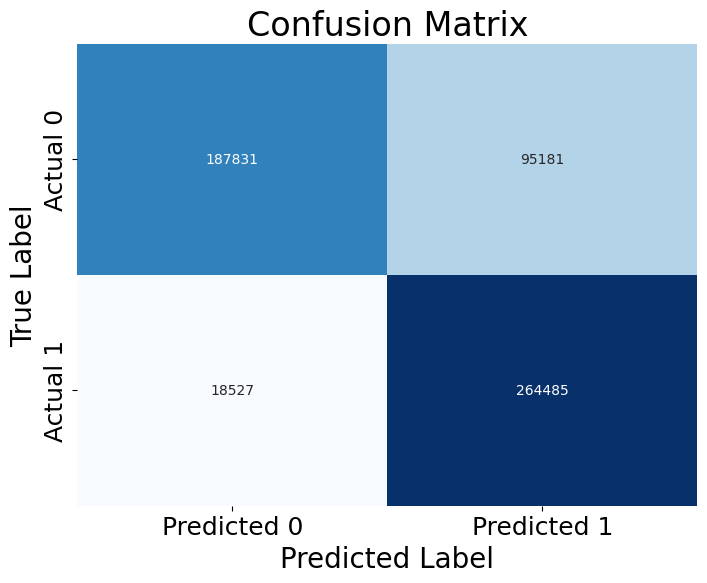

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

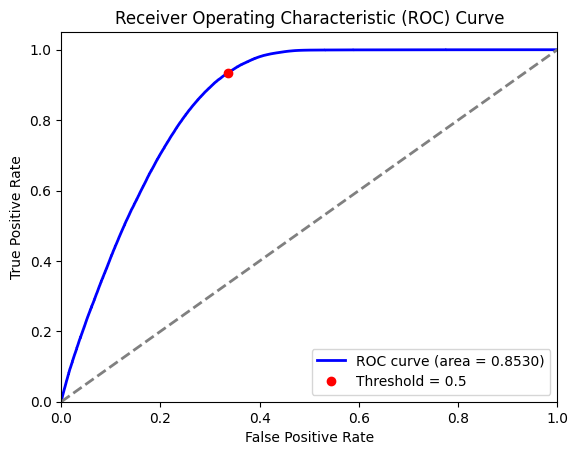

In [24]:
from sklearn.metrics import roc_curve, auc
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot the point at the default threshold of 0.5
default_threshold_index = np.where(thresholds > 0.5)[0][-1]
plt.plot(fpr[default_threshold_index], tpr[default_threshold_index], 'ro', label='Threshold = 0.5')
plt.legend(loc="lower right")

plt.show()

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,461 (2.03 MB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 354,308 (1.35 MB)

# Submission

In [26]:
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

In [27]:
test.set_index('id', inplace=True)
test.drop(columns=['Driving_License'], inplace=True)
test.drop(columns=['Region_Code'], inplace=True)
test.drop(columns=['Policy_Sales_Channel'], inplace=True)

In [28]:
%%time
y_hat = model.predict(pd.DataFrame(prep.fit_transform(test)), verbose=0)

CPU times: user 11min 32s, sys: 52.3 s, total: 12min 25s
Wall time: 9min 39s


In [29]:
submission = pd.DataFrame(test.reset_index().id).assign(Response=y_hat)
submission

,id,Response
0,11504798,0.114
1,11504799,0.757
2,11504800,0.699
3,11504801,0.000
4,11504802,0.217
...,...,...
7669861,19174659,0.683
7669862,19174660,0.001
7669863,19174661,0.002
7669864,19174662,0.799


In [30]:
submission.to_csv('submission.csv', index=False)